# Isolated substorm detection using autoencoders

Substorms are of particular interest to researchers. They are a common phenomenon and it is difficult to detect isolated events for study. Finding such events must be done by hand which is a tedious task.

In the following we study the application of autoencoders to the problem of detecting substorm events. 

## Common imports

[isolated_substorms.dataset](file:///home/aschulz/isolated_substorms/isolated_substorms/dataset.py) : Full input data.

[isolated_substorms.labels](file:///home/aschulz/isolated_substorms/isolated_substorms/labels.py) : Full labels.

[isolated_substorms.train_history](file:///home/aschulz/isolated_substorms/isolated_substorms/train_history.py) : Training history module.

[isolated_substorms.autoencoder](file:///home/aschulz/isolated_substorms/isolated_substorms/autoencoder.py) : Autoencoder base class.

[isolated_substorms.metrics](file:///home/aschulz/isolated_substorms/isolated_substorms/metrics.py) : F1 score and other metrics.


In [1]:
import sys
sys.path.insert(0,"..")

import datetime
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
import torch.optim as optim

# kNN
from sklearn import neighbors

# Data loader class
from isolated_substorms.dataset import Dataset
# Label loader class
from isolated_substorms.labels import EventLabels
# Autoencoder classes
from isolated_substorms.train_history import TrainHistory
from isolated_substorms.autoencoder import Encoder, Decoder, TrainableAutoencoder, TestAutoencoder
# f1 score
from isolated_substorms.metrics import f1_score

In [2]:
# configuration
pickle_filename="autoencoder_feature_data.pkl"


## Load data

First load the full historical AL data and the labels. We then extract data for training and validation. Test data is all data that hasn't been labeled.

In [3]:
# get the labels
labels=EventLabels()
print("Number of events         : {}".format(labels.size()))
print("Label timespan           : {}".format(labels.timespan()))

# get AL data
historical_data=Dataset()
# keep only data for which we have labels
labeled_data=historical_data.get_timespan(labels.timespan())
print("Labeled data shape       : {}".format(labeled_data.shape))
p=100.*float(labeled_data.shape[0])/historical_data.data.shape[0]
print("Proportion of total data : {} %".format(p))

Number of events         : 76
Label timespan           : 1992-10-13 06:27:26 -> 1993-02-15 01:33:40
Labeled data shape       : (179946,)
Proportion of total data : 3.416106383657303 %


### Data description

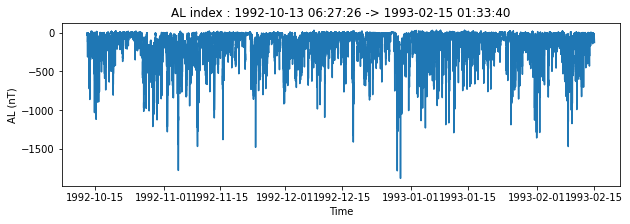

In [4]:
# plot the AL index 
plt.figure(figsize=(10,3))
plt.plot(labeled_data)
plt.title("AL index : {}".format(labels.timespan()))
plt.xlabel("Time")
plt.ylabel("AL (nT)")
plt.show()

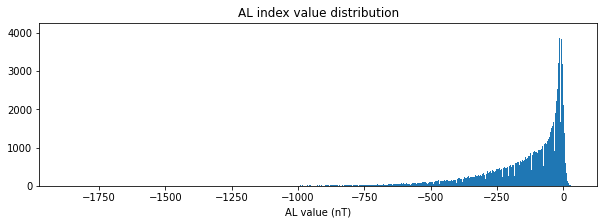

In [5]:
# AL index value distribution
plt.figure(figsize=(10,3))
plt.title("AL index value distribution")
plt.hist(labeled_data, bins=1000)
plt.xlabel("AL value (nT)")
plt.show()

## Training data

The presence of a substorm event at time `t` is dictated by the behaviour of the index `before` and `after` time `t`. Each sample given to our detection model will be a window of size `window_size` centered on the event onset.

We chose a `window_size` of 180 points, representing 3 hours of data.

To avoid generating the features everytime we restart the kernel we will save the data with pickle in the `autoencoder_feature_data.pkl`.

In [6]:
# convert dataset and labels to features that we can use to train the model
def dataset_to_features(data, labels, window_size=180):
    n=data.shape[0]
    w_delta=int(window_size/2)
    # feature and label containers
    x,y=np.empty((n-window_size,window_size)),np.empty(n-window_size)
    for i in range(w_delta,n-w_delta):
        x[i-w_delta]=data[i-w_delta:i+w_delta].to_numpy()
        y[i-w_delta]=labels.check_date(data.index[i])
    return x,y

if not os.path.exists(pickle_filename):
    print("Saving features to {}".format(pickle_filename))
    x,y=dataset_to_features(labeled_data, labels)
    pkl.dump((x,y),open(pickle_filename,"wb"))
else:
    print("Loading features from {}".format(pickle_filename))
    x,y=pkl.load(open(pickle_filename,"rb"))

Loading features from autoencoder_feature_data.pkl


Split the data into training and validation sets.

In [7]:
# split into training and validation sets
def split_data(x,y,p=.5):
    n=x.shape[0]
    np=int(p*n)
    return torch.from_numpy(x[:np]).float(),\
           torch.from_numpy(y[:np]).float(),\
           torch.from_numpy(x[np:]).float(),\
           torch.from_numpy(y[np:]).float()

x_train,y_train,x_validation,y_validation=split_data(x,y,.66)

## Autoencoder initialization

In [8]:
encoding_dim=2
class EncoderA(Encoder):
    def __init__(self):
        super(EncoderA,self).__init__()
        self.l1=torch.nn.Linear(180,encoding_dim)
    def forward(self, x):
        x=self.l1(x)
        return x
class DecoderA(Decoder):
    def __init__(self):
        super(DecoderA,self).__init__()
        self.l1=torch.nn.Linear(encoding_dim,180)
    def forward(self, x):
        x=self.l1(x)
        return x


### Training the model

Parameters used for training. Implemented early stopping with patience value of 10.

| Parameter            | Variable name | Value |
| -------------------- |:-------------:| -----:|
| learning rate        | lr            | 1.e-6 |
| validation tolerance | validation_tol| 1.e-4 |

--validation score not improving. ending training


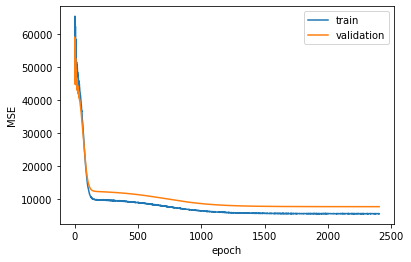

In [9]:
lr=0.000001
validation_tol=1.e+4
autoencoder=TrainableAutoencoder(encoder=EncoderA(),\
                                 decoder=DecoderA())
train_history = autoencoder.train(x_train, x_train,\
                                  x_validation, x_validation,\
                                  lr=lr,\
                                  val_tol=validation_tol)
train_loss_fig=train_history.plot()
plt.show()

### Prediction

Lets plot the encoded data in the first two dimensions of the encoding space. The `positive` labels are shown in red and the `negative` samples blue. The hope is that the encoded data will have evident clusters. Predicting is then done by using k-Nearest Neighbors algorithm.

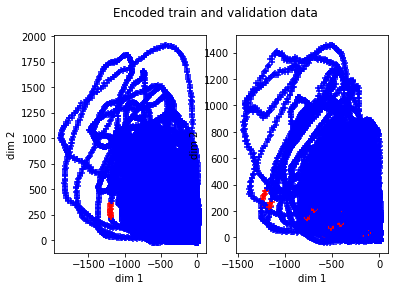

In [10]:
# plot train and validation encoded data
with torch.no_grad():
    encoded_train=autoencoder.encoder(x_train)
    encoded_validation=autoencoder.encoder(x_validation)
# map labels to colors
cmap={0:"b",1:"r"}
colors_train=[cmap[int(k.item())] for k in y_train]
colors_validation=[cmap[int(k.item())] for k in y_validation]

plt.figure()
plt.suptitle("Encoded train and validation data")
plt.subplot(1,2,1)
plt.scatter(encoded_train[:,0],encoded_train[:,1],\
            marker="+",c=colors_train)
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.subplot(1,2,2)
plt.scatter(encoded_validation[:,0],encoded_validation[:,1],\
           marker="+",c=colors_validation)
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.show()

It is difficult to distinguish any clusters due to the fact that the `negative` samples far outnumber the `positive` samples. 

For future reference we will evaluate the current models performance on the full labeled dataset.

## k-NN classifier
Train the classifier on the train data.

In [11]:
# classifier initializing and training
clf=neighbors.KNeighborsClassifier(n_neighbors=10, weights="uniform")
clf.fit(encoded_train, y_train)
prediction_train=clf.predict(encoded_train)
confusion_matrix=pd.crosstab(pd.Series(name="predicted",data=prediction_train),\
                  pd.Series(name="actual",data=y_train))
print("Confusion matrix :\n{}".format(confusion_matrix))
print("F1 score         : {}".format(f1_score(prediction_train,y_train)))


Confusion matrix :
actual        0.0  1.0
predicted             
0.0        118469  159
1.0             0   17
F1 score         : 0.17616580310880828


How does the `F1 score` evolve as a function of the number of neighbors ?

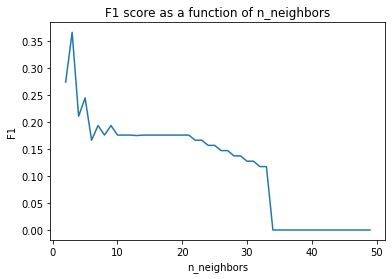

In [12]:
n_neighbors=[nei for nei in range(2,50)]
scores=np.empty(len(n_neighbors))
for i in range(len(n_neighbors)):
    #print("n_neighbors={}".format(n_neighbors[i]))
    clf=neighbors.KNeighborsClassifier(n_neighbors=n_neighbors[i], weights="uniform")
    clf.fit(encoded_train, y_train)
    prediction=clf.predict(encoded_train)
    scores[i]=f1_score(prediction,y_train)

plt.figure()
plt.title("F1 score as a function of n_neighbors")
plt.plot(n_neighbors, scores)
plt.xlabel("n_neighbors")
plt.ylabel("F1")
plt.show()